In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [2]:
!pip install mlflow

     |████████████████████████████████| 14.6 MB 123 kB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 146 kB 45.0 MB/s 
     |████████████████████████████████| 180 kB 50.5 MB/s 
     |████████████████████████████████| 1.1 MB 45.2 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=f579aba53712697df50e83e8e9e5fe1f4537799cd8007fd64937a5e607a51603
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.15.0-py3-none-any.whl size=105260 sha256=6423980be95fbcbffe2b3d3c9210c7cb2fec6aa9e22eb65f2c09bf37a5cd44b

In [3]:
import mlflow
import mlflow.pytorch

#Param Class

In [4]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(256, 4, 0, 20)

#DataSet

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('../data', train=True, download=True, 
                         transform=transform)

test_set = datasets.MNIST('../data', train=False, download=True, 
                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#Model

In [6]:
class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))

In [8]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10])
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            
            for x, y in zip(pred.numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100.0 * correct / len(test_loader.dataset)
        
        pos = (epoch + 1) * len(train_loader)
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset), test_accuracy))
        return correct
        '''if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
              
            fig.tight_layout()
              
            #image_path = 'images/%s.png' % (expt_id)
            #plt.savefig(image_path)
            #mlflow.log_artifact(image_path)'''
            

#Hyper-Parameter_tuning

In [13]:
class best_Params(object):
    def __init__(self, Lr, epochs, Accuracy, mom, hidden):
        self.LR = Lr
        self.epochs = epochs
        self.accuracy = Accuracy
        self.mom_speed = mom
        self.hidden_node = hidden

In [14]:
best_params = best_Params(0,0,0,0,0)

In [15]:
# expt_id = mlflow.create_experiment('Fixed nH')

mlflow.set_experiment('Fixed nH')
min_ = 0
for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [16,24,32,48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(epoch)
                    max_accuracy = test(epoch)
                    if(max_accuracy > min_):
                      min_ = max_accuracy
                      best_params.LR = lr
                      best_params.epochs = epoch
                      best_params.accuracy = max_accuracy
                      best_params.mom_speed = momentum
                      best_params.hidden_node = hidden_nodes

                mlflow.pytorch.log_model(model, "models")


LR = 0.01, Momentum = 0.90, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.295
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.636
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.507
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.373
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.555
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.282
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.422
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.365
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.374
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.289
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.311

Test set: Average loss: 0.0012, Accuracy: 9087/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.368
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.267
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.277
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.271
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.294
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.382
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.205
Train Epoch:

2021/10/18 12:28:42 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:28:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0008, Accuracy: 9378/10000 (94%)



2021/10/18 12:28:45 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.90, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.150
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.498
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.551
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.469
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.380
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.295
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.286
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.292
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.326
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.349
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.164

Test set: Average loss: 0.0012, Accuracy: 9141/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.264
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.379
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.367
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.278
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.222
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.353
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.239
Train Epoch:

2021/10/18 12:29:29 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:29:29 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0007, Accuracy: 9462/10000 (95%)



2021/10/18 12:29:32 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.90, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.356
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.054
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.602
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.393
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.419
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.340
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.355
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.377
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.197
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.263
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.212
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.244

Test set: Average loss: 0.0011, Accuracy: 9212/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.260
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.275
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.329
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.244
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.215
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.234
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.265
Train Epoch:

2021/10/18 12:30:16 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:30:16 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0006, Accuracy: 9527/10000 (95%)



2021/10/18 12:30:19 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.341
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.921
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.525
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.383
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.387
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.399
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.377
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.398
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.264
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.347
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.264
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.320

Test set: Average loss: 0.0011, Accuracy: 9215/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.224
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.245
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.246
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.365
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.236
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.247
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.313
Train Epoch:

2021/10/18 12:31:04 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:31:04 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0006, Accuracy: 9525/10000 (95%)



2021/10/18 12:31:06 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.95, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.069
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.566
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.359
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.352
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.386
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.337
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.324
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.359
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.223
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.280
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.331

Test set: Average loss: 0.0011, Accuracy: 9172/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.341
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.308
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.278
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.324
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.155
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.230
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.331
Train Epoch:

2021/10/18 12:31:50 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:31:50 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0008, Accuracy: 9373/10000 (94%)



2021/10/18 12:31:53 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.95, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.376
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.908
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.397
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.573
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.474
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.431
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.410
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.304
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.254
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.272
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.231
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.227

Test set: Average loss: 0.0009, Accuracy: 9302/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.208
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.169
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.300
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.343
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.195
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.251
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.228
Train Epoch:

2021/10/18 12:32:40 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:32:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0006, Accuracy: 9517/10000 (95%)



2021/10/18 12:32:44 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.95, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.911
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.441
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.404
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.334
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.319
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.357
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.344
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.298
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.306
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.334
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.261

Test set: Average loss: 0.0011, Accuracy: 9244/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.345
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.286
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.312
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.209
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.280
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.262
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.256
Train Epoch:

2021/10/18 12:33:29 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:33:29 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0006, Accuracy: 9557/10000 (96%)



2021/10/18 12:33:31 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.808
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.509
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.380
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.407
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.392
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.281
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.337
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.182
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.213
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.227
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.262

Test set: Average loss: 0.0010, Accuracy: 9274/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.219
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.333
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.161
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.191
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.205
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.234
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.160
Train Epoch:

2021/10/18 12:34:16 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:34:16 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9614/10000 (96%)



2021/10/18 12:34:18 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.99, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.359
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.039
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.738
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.971
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.911
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.917
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.773
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.872
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.658
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.598
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.752
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.483

Test set: Average loss: 0.0019, Accuracy: 8665/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.557
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.401
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.481
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.482
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.385
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.402
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.356
Train Epoch:

2021/10/18 12:35:03 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:35:03 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0009, Accuracy: 9346/10000 (93%)



2021/10/18 12:35:05 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.99, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.851
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.586
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.720
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.806
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.470
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.559
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.677
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.355
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.365
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.586
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.498

Test set: Average loss: 0.0015, Accuracy: 8964/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.477
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.372
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.600
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.568
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.384
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.290
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.243
Train Epoch:

2021/10/18 12:35:49 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:35:49 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0007, Accuracy: 9463/10000 (95%)



2021/10/18 12:35:52 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.99, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.975
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.758
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.784
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.862
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.546
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.712
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.351
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.693
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.670
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.645
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.524

Test set: Average loss: 0.0017, Accuracy: 8926/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.381
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.437
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.225
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.289
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.340
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.377
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.339
Train Epoch:

2021/10/18 12:36:36 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:36:36 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0007, Accuracy: 9500/10000 (95%)



2021/10/18 12:36:39 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.01, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.741
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.689
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.945
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.992
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.728
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.876
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.869
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.376
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.365
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.386
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.406

Test set: Average loss: 0.0014, Accuracy: 9041/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.423
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.240
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.293
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.365
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.403
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.253
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.277
Train Epoch:

2021/10/18 12:37:24 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:37:24 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0006, Accuracy: 9600/10000 (96%)



2021/10/18 12:37:26 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.90, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.824
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.393
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.467
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.370
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.307
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.329
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.282
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.282
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.359
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.318
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.260

Test set: Average loss: 0.0011, Accuracy: 9204/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.304
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.295
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.218
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.231
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.222
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.295
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.282
Train Epoch:

2021/10/18 12:38:10 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:38:10 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0008, Accuracy: 9404/10000 (94%)



2021/10/18 12:38:13 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.90, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.632
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.457
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.384
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.247
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.367
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.244
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.292
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.301
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.309
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.296
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.207

Test set: Average loss: 0.0010, Accuracy: 9213/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.322
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.212
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.180
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.173
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.226
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.124
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.138
Train Epoch:

2021/10/18 12:38:57 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:38:57 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0006, Accuracy: 9527/10000 (95%)



2021/10/18 12:39:00 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.90, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.668
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.551
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.336
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.344
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.357
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.249
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.259
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.191
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.221
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.161
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.193

Test set: Average loss: 0.0009, Accuracy: 9340/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.180
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.220
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.270
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.266
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.264
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.156
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.153
Train Epoch:

2021/10/18 12:39:45 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:39:45 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9618/10000 (96%)



2021/10/18 12:39:47 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.739
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.435
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.347
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.309
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.307
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.162
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.290
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.319
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.267
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.251
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.179

Test set: Average loss: 0.0009, Accuracy: 9314/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.184
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.232
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.201
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.197
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.207
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.135
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.173
Train Epoch:

2021/10/18 12:40:33 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:40:33 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9637/10000 (96%)



2021/10/18 12:40:35 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.95, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.711
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.584
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.359
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.356
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.368
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.308
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.274
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.308
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.208
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.232
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.129

Test set: Average loss: 0.0009, Accuracy: 9302/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.216
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.240
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.234
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.295
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.246
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.278
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.167
Train Epoch:

2021/10/18 12:41:19 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:41:19 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0007, Accuracy: 9441/10000 (94%)



2021/10/18 12:41:21 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.95, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.361
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.766
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.364
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.271
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.344
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.208
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.238
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.290
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.311
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.245
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.263
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.156

Test set: Average loss: 0.0009, Accuracy: 9371/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.224
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.214
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.172
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.169
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.211
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.183
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.159
Train Epoch:

2021/10/18 12:42:06 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:42:06 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9587/10000 (96%)



2021/10/18 12:42:08 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.95, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.604
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.459
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.488
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.369
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.248
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.383
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.266
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.240
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.227
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.201
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.311

Test set: Average loss: 0.0009, Accuracy: 9337/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.270
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.190
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.193
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.262
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.204
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.177
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.161
Train Epoch:

2021/10/18 12:42:52 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:42:52 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9597/10000 (96%)



2021/10/18 12:42:55 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.523
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.825
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.533
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.284
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.222
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.217
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.253
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.246
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.135
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.199
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.152

Test set: Average loss: 0.0007, Accuracy: 9455/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.222
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.195
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.148
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.155
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.078
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.076
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.111
Train Epoch:

2021/10/18 12:43:40 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:43:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0004, Accuracy: 9663/10000 (97%)



2021/10/18 12:43:42 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.99, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.720
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.831
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.988
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.846
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.639
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.711
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.659
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.785
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.579
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.909
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.441

Test set: Average loss: 0.0022, Accuracy: 8559/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.362
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.433
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.417
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.350
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.519
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.329
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.574
Train Epoch:

2021/10/18 12:44:26 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:44:26 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0014, Accuracy: 9130/10000 (91%)



2021/10/18 12:44:28 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.99, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.370
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.628
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.120
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.554
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.615
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.719
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.019
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.082
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.016
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.884
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.580
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.865

Test set: Average loss: 0.0025, Accuracy: 8297/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.495
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.792
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.549
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.512
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.540
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.430
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.475
Train Epoch:

2021/10/18 12:45:13 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:45:13 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0012, Accuracy: 9252/10000 (93%)



2021/10/18 12:45:15 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.99, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.647
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.727
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.513
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.055
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.763
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.804
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.672
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.872
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.738
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.392
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.447

Test set: Average loss: 0.0021, Accuracy: 8730/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.593
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.484
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.408
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.507
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.502
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.393
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.403
Train Epoch:

2021/10/18 12:46:00 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:46:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0011, Accuracy: 9276/10000 (93%)



2021/10/18 12:46:02 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.02, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.587
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.856
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.483
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.056
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.609
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.629
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.685
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.387
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.562
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.482
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.730

Test set: Average loss: 0.0019, Accuracy: 8777/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.315
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.402
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.432
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.354
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.208
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.431
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.351
Train Epoch:

2021/10/18 12:46:47 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:46:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0011, Accuracy: 9307/10000 (93%)



2021/10/18 12:46:49 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.90, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.775
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.381
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.342
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.302
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.319
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.307
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.461
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.326
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.305
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.213
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.247

Test set: Average loss: 0.0008, Accuracy: 9340/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.241
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.209
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.258
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.193
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.213
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.240
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.228
Train Epoch:

2021/10/18 12:47:33 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:47:33 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0007, Accuracy: 9457/10000 (95%)



2021/10/18 12:47:35 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.90, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.409
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.374
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.480
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.280
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.195
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.330
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.373
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.353
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.226
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.258
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.259
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.333

Test set: Average loss: 0.0008, Accuracy: 9402/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.207
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.230
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.149
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.192
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.197
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.161
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.140
Train Epoch:

2021/10/18 12:48:20 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:48:20 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9654/10000 (97%)



2021/10/18 12:48:22 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.90, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.328
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.414
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.393
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.276
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.362
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.323
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.223
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.197
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.240
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.257
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.178
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.189

Test set: Average loss: 0.0007, Accuracy: 9487/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.154
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.163
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.141
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.193
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.192
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.123
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.195
Train Epoch:

2021/10/18 12:49:06 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:49:06 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9615/10000 (96%)



2021/10/18 12:49:09 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.354
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.643
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.518
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.290
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.271
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.225
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.212
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.191
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.225
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.254
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.226
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.183

Test set: Average loss: 0.0006, Accuracy: 9542/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.156
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.143
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.078
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.114
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.141
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.158
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.131
Train Epoch:

2021/10/18 12:49:54 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:49:54 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0004, Accuracy: 9681/10000 (97%)



2021/10/18 12:49:56 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.95, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.626
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.495
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.523
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.394
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.307
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.326
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.260
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.398
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.344
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.239
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.371

Test set: Average loss: 0.0009, Accuracy: 9303/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.166
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.262
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.304
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.310
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.187
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.184
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.172
Train Epoch:

2021/10/18 12:50:40 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:50:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0008, Accuracy: 9410/10000 (94%)



2021/10/18 12:50:42 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.95, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.574
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.886
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.467
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.415
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.281
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.185
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.274
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.304
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.227
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.206
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.297

Test set: Average loss: 0.0008, Accuracy: 9375/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.162
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.194
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.217
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.147
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.171
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.204
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.181
Train Epoch:

2021/10/18 12:51:27 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:51:27 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0007, Accuracy: 9531/10000 (95%)



2021/10/18 12:51:29 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.95, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.558
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.512
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.465
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.441
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.332
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.257
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.209
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.161
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.279
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.234
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.184

Test set: Average loss: 0.0007, Accuracy: 9448/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.219
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.234
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.194
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.171
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.160
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.190
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.108
Train Epoch:

2021/10/18 12:52:14 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:52:14 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9598/10000 (96%)



2021/10/18 12:52:16 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.373
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.621
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.584
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.431
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.443
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.216
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.199
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.273
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.141
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.160
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.127
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.154

Test set: Average loss: 0.0006, Accuracy: 9518/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.158
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.178
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.084
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.187
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.101
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.171
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.138
Train Epoch:

2021/10/18 12:53:01 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:53:01 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0004, Accuracy: 9664/10000 (97%)



2021/10/18 12:53:03 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.99, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.704
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.421
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.062
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.320
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.822
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.095
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.011
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.970
Train Epoch: 1 [46080/60000 (77%)]	Loss: 1.542
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.040
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.907

Test set: Average loss: 0.0038, Accuracy: 7816/10000 (78%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.842
Train Epoch: 2 [5120/60000 (9%)]	Loss: 1.109
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.755
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.915
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.401
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.904
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.907
Train Epoch:

2021/10/18 12:53:48 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:53:48 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0042, Accuracy: 6443/10000 (64%)



2021/10/18 12:53:50 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.99, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.419
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.850
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.335
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.542
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.000
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.920
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.052
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.123
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.986
Train Epoch: 1 [46080/60000 (77%)]	Loss: 1.134
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.753
Train Epoch: 1 [56320/60000 (94%)]	Loss: 1.345

Test set: Average loss: 0.0035, Accuracy: 7848/10000 (78%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.142
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.782
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.935
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.882
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.890
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.979
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.003
Train Epoch:

2021/10/18 12:54:34 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:54:34 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0038, Accuracy: 7358/10000 (74%)



2021/10/18 12:54:37 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.99, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.041
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.048
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.699
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.761
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.774
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.606
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.631
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.554
Train Epoch: 1 [46080/60000 (77%)]	Loss: 1.007
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.873
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.762

Test set: Average loss: 0.0030, Accuracy: 8055/10000 (81%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.773
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.898
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.840
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.786
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.574
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.524
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.545
Train Epoch:

2021/10/18 12:55:21 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:55:21 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0025, Accuracy: 8462/10000 (85%)



2021/10/18 12:55:23 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.05, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.856
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.279
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.968
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.588
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.989
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.034
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.950
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.515
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.788
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.824
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.666

Test set: Average loss: 0.0026, Accuracy: 8448/10000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.518
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.632
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.704
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.547
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.799
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.587
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.566
Train Epoch:

2021/10/18 12:56:08 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:56:08 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0032, Accuracy: 8266/10000 (83%)



2021/10/18 12:56:10 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.90, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.752
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.447
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.382
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.332
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.318
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.311
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.236
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.219
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.208
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.275
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.266

Test set: Average loss: 0.0009, Accuracy: 9281/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.267
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.238
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.299
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.298
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.229
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.123
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.273
Train Epoch:

2021/10/18 12:56:55 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:56:55 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0008, Accuracy: 9407/10000 (94%)



2021/10/18 12:56:57 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.90, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.335
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.432
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.292
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.240
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.351
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.278
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.247
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.225
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.209
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.208
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.183

Test set: Average loss: 0.0008, Accuracy: 9355/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.251
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.194
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.192
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.180
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.137
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.168
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.160
Train Epoch:

2021/10/18 12:57:41 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:57:41 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0006, Accuracy: 9578/10000 (96%)



2021/10/18 12:57:43 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.90, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.349
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.823
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.434
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.337
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.285
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.191
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.184
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.331
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.319
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.258
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.221
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.170

Test set: Average loss: 0.0007, Accuracy: 9476/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.173
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.179
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.132
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.188
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.131
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.224
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.130
Train Epoch:

2021/10/18 12:58:28 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:58:28 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0005, Accuracy: 9643/10000 (96%)



2021/10/18 12:58:31 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.763
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.346
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.231
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.348
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.220
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.163
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.217
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.210
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.161
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.187
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.128

Test set: Average loss: 0.0006, Accuracy: 9529/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.142
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.145
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.158
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.190
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.153
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.093
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.133
Train Epoch:

2021/10/18 12:59:15 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 12:59:15 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0004, Accuracy: 9692/10000 (97%)



2021/10/18 12:59:17 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.95, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.185
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.662
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.866
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.391
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.534
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.388
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.222
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.298
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.295
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.374
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.294

Test set: Average loss: 0.0011, Accuracy: 9265/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.273
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.250
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.303
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.281
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.305
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.211
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.301
Train Epoch:

2021/10/18 13:00:01 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 13:00:01 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0008, Accuracy: 9417/10000 (94%)



2021/10/18 13:00:04 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.95, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.288
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.964
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.574
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.701
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.435
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.383
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.376
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.304
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.416
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.377
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.253
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.318

Test set: Average loss: 0.0012, Accuracy: 9182/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.302
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.266
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.313
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.261
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.283
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.273
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.294
Train Epoch:

2021/10/18 13:00:48 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 13:00:48 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0008, Accuracy: 9460/10000 (95%)



2021/10/18 13:00:50 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.95, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.314
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.758
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.371
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.484
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.393
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.312
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.327
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.379
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.256
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.238
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.315

Test set: Average loss: 0.0009, Accuracy: 9344/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.162
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.254
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.235
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.156
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.243
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.161
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.169
Train Epoch:

2021/10/18 13:01:35 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 13:01:35 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0007, Accuracy: 9476/10000 (95%)



2021/10/18 13:01:37 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.95, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.848
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.335
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.405
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.406
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.344
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.359
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.365
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.233
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.270
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.151
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.370

Test set: Average loss: 0.0009, Accuracy: 9386/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.186
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.244
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.178
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.135
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.153
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.253
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.255
Train Epoch:

2021/10/18 13:02:22 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 13:02:22 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0007, Accuracy: 9485/10000 (95%)



2021/10/18 13:02:24 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.99, Hidden nodes = 16

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.366
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.739
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.787
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.622
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.944
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.789
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.908
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.657
Train Epoch: 1 [46080/60000 (77%)]	Loss: 2.404
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.271
Train Epoch: 1 [56320/60000 (94%)]	Loss: 1.302

Test set: Average loss: 0.0060, Accuracy: 4885/10000 (49%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.883
Train Epoch: 2 [5120/60000 (9%)]	Loss: 1.522
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.417
Train Epoch: 2 [15360/60000 (26%)]	Loss: 1.267
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.298
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.470
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.819
Train Epoch:

2021/10/18 13:03:08 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 13:03:08 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0077, Accuracy: 2529/10000 (25%)



2021/10/18 13:03:11 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.99, Hidden nodes = 24

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.095
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.310
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.996
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.767
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.268
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.891
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.966
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.274
Train Epoch: 1 [46080/60000 (77%)]	Loss: 1.047
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.286
Train Epoch: 1 [56320/60000 (94%)]	Loss: 1.459

Test set: Average loss: 0.0060, Accuracy: 5055/10000 (51%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.284
Train Epoch: 2 [5120/60000 (9%)]	Loss: 1.271
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.372
Train Epoch: 2 [15360/60000 (26%)]	Loss: 1.457
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.408
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.631
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.277
Train Epoch:

2021/10/18 13:03:55 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 13:03:55 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0069, Accuracy: 3583/10000 (36%)



2021/10/18 13:03:57 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.99, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.272
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.890
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.180
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.193
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.164
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.249
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.222
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.365
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.120
Train Epoch: 1 [46080/60000 (77%)]	Loss: 1.091
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.186
Train Epoch: 1 [56320/60000 (94%)]	Loss: 1.147

Test set: Average loss: 0.0047, Accuracy: 6624/10000 (66%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.885
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.993
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.072
Train Epoch: 2 [15360/60000 (26%)]	Loss: 1.423
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.313
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.082
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.417
Train Epoch:

2021/10/18 13:04:42 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 13:04:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0080, Accuracy: 4183/10000 (42%)



2021/10/18 13:04:44 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



LR = 0.10, Momentum = 0.99, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.358
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.449
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.269
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.654
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.131
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.182
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.028
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.843
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.954
Train Epoch: 1 [46080/60000 (77%)]	Loss: 1.008
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.889
Train Epoch: 1 [56320/60000 (94%)]	Loss: 1.283

Test set: Average loss: 0.0042, Accuracy: 7397/10000 (74%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.101
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.955
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.206
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.829
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.885
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.853
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.998
Train Epoch:

2021/10/18 13:05:29 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/10/18 13:05:29 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Test set: Average loss: 0.0081, Accuracy: 4385/10000 (44%)



2021/10/18 13:05:31 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [17]:
print("Learning rate = " + str(best_params.LR),
      "Epochs = " + str(best_params.epochs),
      "Accuracy = " + str(best_params.accuracy),
      "Momentum = " + str(best_params.mom_speed),
      "Hidden nodes = " + str(best_params.hidden_node))

Learning rate = 0.1 Epochs = 4 Accuracy = 9692 Momentum = 0.9 Hidden nodes = 48


In [35]:
import copy as cp

In [20]:
model = Model(best_params.hidden_node)

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=best_params.LR, momentum = best_params.mom_speed)

In [36]:
loss_rate = []
accuracy_rate = []
min_ = 0
for epoch in range(20):
  for batch_id, data in enumerate(train_loader):
      inputs, labels = data
      opt.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      opt.step()
  test_loss = 0
  correct = 0
  for inputs, labels in test_loader:
    outputs = model(inputs)
    test_loss += loss_fn(outputs, labels).data.item()
    pred = outputs.data.max(1)[1]
    correct += pred.eq(labels.data).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100.0 * correct / len(test_loader.dataset)
  if test_accuracy > min_:
    min_ = test_accuracy
    best_model = copy.deepcopy(model.state_dict())
  print(f"Epochs: {epoch} test_loss: {test_loss} test_accuracy: {test_accuracy}")
  accuracy_rate.append(test_accuracy)
  loss_rate.append(test_loss)

Epochs: 0 test_loss: 0.0008112930013647485 test_accuracy: 97.22
Epochs: 1 test_loss: 0.0008389498949723929 test_accuracy: 97.15
Epochs: 2 test_loss: 0.0008362845484982223 test_accuracy: 97.16
Epochs: 3 test_loss: 0.0008335817171252358 test_accuracy: 97.11
Epochs: 4 test_loss: 0.0008762743358427542 test_accuracy: 97.08
Epochs: 5 test_loss: 0.0009309385764580696 test_accuracy: 97.08
Epochs: 6 test_loss: 0.0008688167208067029 test_accuracy: 97.09
Epochs: 7 test_loss: 0.0008422613168113447 test_accuracy: 97.15
Epochs: 8 test_loss: 0.0008990603000989722 test_accuracy: 97.2
Epochs: 9 test_loss: 0.0008065345814631407 test_accuracy: 97.36
Epochs: 10 test_loss: 0.0008408655458667454 test_accuracy: 97.36
Epochs: 11 test_loss: 0.0008212700306246233 test_accuracy: 97.42
Epochs: 12 test_loss: 0.0008271416461471589 test_accuracy: 97.38
Epochs: 13 test_loss: 0.0008239659792034207 test_accuracy: 97.38
Epochs: 14 test_loss: 0.000827005000039108 test_accuracy: 97.43
Epochs: 15 test_loss: 0.0008278517819

In [ ]:
print(best_model)

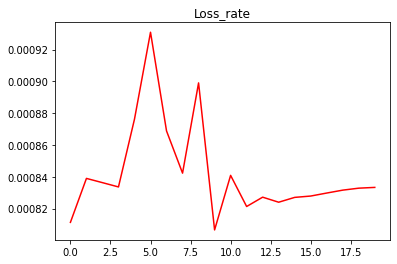

In [40]:
x = range(0,20)
plt.plot(x,loss_rate, color = "red")
plt.title("Loss_rate")
plt.show()

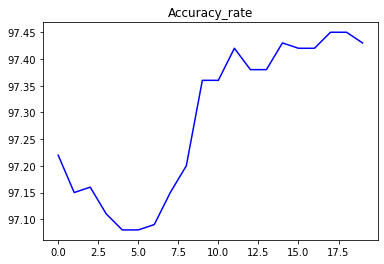

In [41]:
x = range(0,20)
plt.plot(x,accuracy_rate, color = "blue")
plt.title("Accuracy_rate")
plt.show()

In [44]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [45]:
print(model)

Model(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=10, bias=True)
  )
)


In [46]:
weight_layer0 = list(model.parameters())[0].data.numpy()

In [47]:
print(weight_layer0.shape)

(48, 784)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

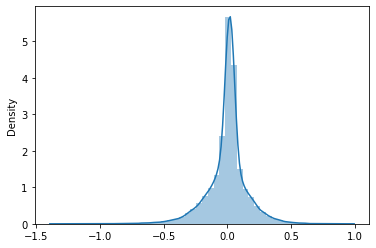

In [48]:
sns.distplot(weight_layer0.ravel())
plt.plot()

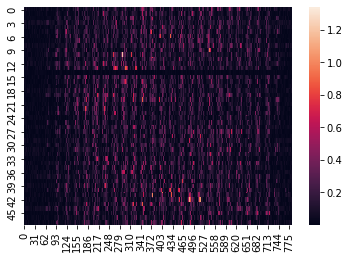

In [49]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [50]:
weight_layer1 = list(model.parameters())[2].data.numpy()

In [51]:
weight_layer1.shape

(10, 48)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

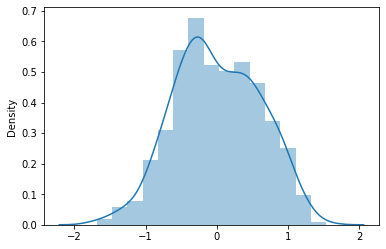

In [52]:
sns.distplot(weight_layer1.ravel())
plt.plot()

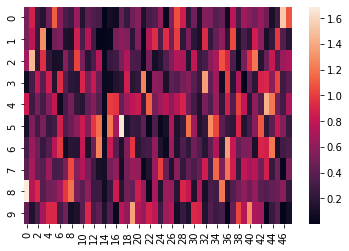

In [53]:
sns.heatmap(np.abs(weight_layer1))
plt.show()

In [ ]:
'''class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x'''

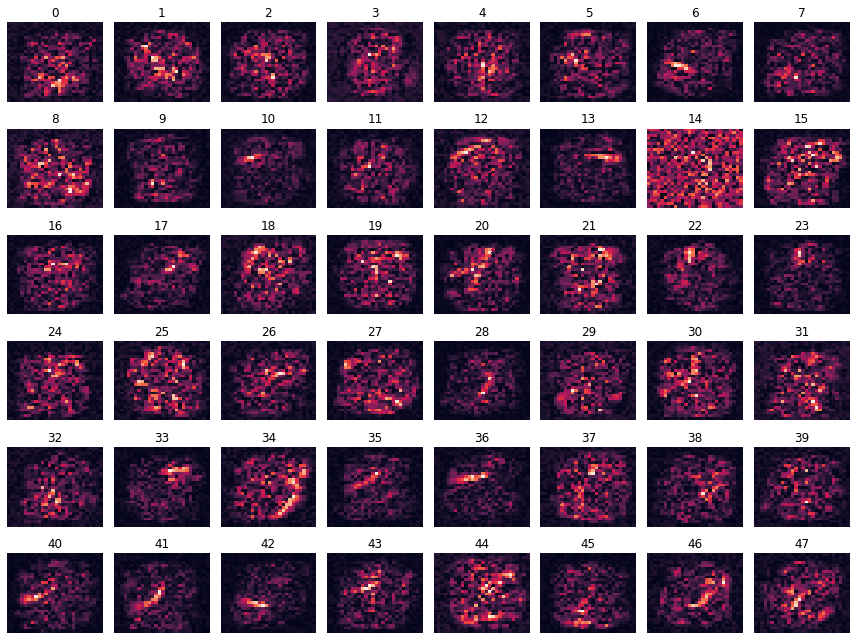

In [56]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48): 
    ax1 = fig.add_subplot(nrows, ncols, i+1)
    sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28, 28)), ax = ax1, cbar= False)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title(i)
plt.tight_layout()
plt.show()